In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from copy import  deepcopy
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [4]:
import os
os.chdir('/home/yash/Documents/EWC/Elastic-Weight-Consolidation')
from model import Model


In [5]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28, 28]), cmap='gray')
    plt.axis('off')

# return a new mnist dataset w/ pixels randomly permuted
def permute_mnist(mnist):
    perm_inds = range(mnist.train.images.shape[1])
#     print (range(mnist.train.images.shape[1]))
    np.random.shuffle(perm_inds)
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) # shallow copy
#         print (np.array([this_set.images[:,i] for i in [1,2,3,4]]).shape)
        #dafaq is with ._images, where did this shit come from, but okay moving on with lyf 
        this_set._images = np.transpose(np.array([this_set.images[:,c] for c in perm_inds]))
    return mnist2

In [6]:
def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0, 1)
    display.display(plt.gcf())
    display.clear_output(wait=True)



def train_model(model, train_set, test_sets, num_iters=1000, disp_freq=50, lams=[0]):
    for l in range(len(lams)):
        if lams[l] == 0:
            model.vanilla_loss()
        else:
            model.ewc_loss(lams[l])

        test_accs = []
        for i in range(len(test_sets)):
            test_accs.append(np.zeros(num_iters / disp_freq))

        for it in range(num_iters):
            train_batch = train_set.train.next_batch(100)
            feed_dict = {x: train_batch[0], y_: train_batch[1]}
            model.train_step.run(feed_dict=feed_dict)
            
            if it%disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                
                for task in range(len(test_sets)):
                    index = it/disp_freq
                    feed_dict = {x: test_sets[task].test.images, y_:test_sets[task].test.labels}
                    test_accs[task][index] = model.accuracy.eval(feed_dict=feed_dict)
                    task_char = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1, it+2, disp_freq), test_accs[task][:index+1], colors[task],
                                       label = "Task" + task_char)
                    plots.append(plot_h)
#                     print(test_accs)
                
                plot_test_acc(plots)
                
                if lams[l] == 0:
                    plt.title("Vanilla SGD")
                else:
                    plt.title("EWC")
                
                plt.gcf().set_size_inches(len(lams)*5, 3.5)

In [7]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()

# define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
# instantiate new model
model = Model(x, y_) # simple 2-layer network
sess.run(tf.global_variables_initializer())

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



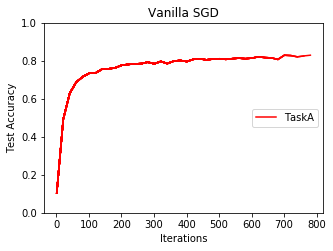

In [9]:
train_model(model, mnist, [mnist], 800, 20)